# Prepoznavanje znamenaka 0-9

Neuronske mreže predstavljaju veoma napredan koncept neuroračunarstva. U nastavku ovog rada, iskoristit ćemo strukturu umjetne neuronske mreže u svrhu prepoznavanja znamenaka dekadskog sustava. Ključne biblioteke koje ćemo koristiti bit će <i>tensorflow</i>, odnosno <i>keras</i>. U skladu s tim, prije svakog korištenja nekog od alata (funkcija, struktura itd.) iz navedenih biblioteka, opisat ćemo pobliže njihovu namjenu i značenje njihovih parametara. Kako bismo mogli vizualizirati uspješnost modela, iskoristit ćemo biblioteku <i>matplotlib</i>, a za praktično skladištenje i modificiranje slika u polju koristimo <i>numpy</i> biblioteku. 

In [10]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

### Prikupljanje i modifikacija podataka

<i>Keras</i> biblioteka sadržana je unutar <i>tensorflow-a</i>, a glavna namjena joj je obavljanje složenih zadataka strojnog učenja u području umjenih neuronskih mreža. No, uz brojne napredne funkcije, strukture i slično, ona posjeduje i ogromnu kolekciju podataka. Među njima se nalaze i slike dekadskih znamenaka koje dobivamo pozivom funkcije <i>keras.datasets.mnist.load_data()</i>. Ta funkcija vraća dva uređena para od kojih se svaki sastoji od niza slika znamenki te njihovih klasifikacija. Prvi uređeni par koristit će se za treniranje modela, a drugi za njegovo testiranje.

In [11]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

U nastavku provjeravamo koliko smo točno dobili slika za treniranje i testiranje.

In [5]:
len(X_train)

60000

In [6]:
len(X_test)

10000

Da bismo izgradili odgovarajuću umjetnu neuronsku mrežu, potrebno je saznati prirodu, odnosno strukturu elemenata koje klasificiramo. To provjeravamo u sljedećih nekoliko linija koda. Ukratko: pojedina slika je zapravo matrica reda 28 u kojoj svaki element predstavlja intenzitet boje piksela koji čini sliku, a čija vrijednost varira između 0 i 255 pa su slike crno-bijele. Naravno, 0 predstavlja crnu, a 255 bijelu boju. 

In [7]:
X_train[0].shape

(28, 28)

In [8]:
X_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

Iznad smo vidjeli kako je slika reprezentirana u računalu, a ispod prikazujemo prvih 5 slika iz skupa podataka za treniranje. Ujedno smo iskoristili i drugi element <i>y_train</i> uređenog para kojeg je vratila gornja funkcija za dohvat podataka. 

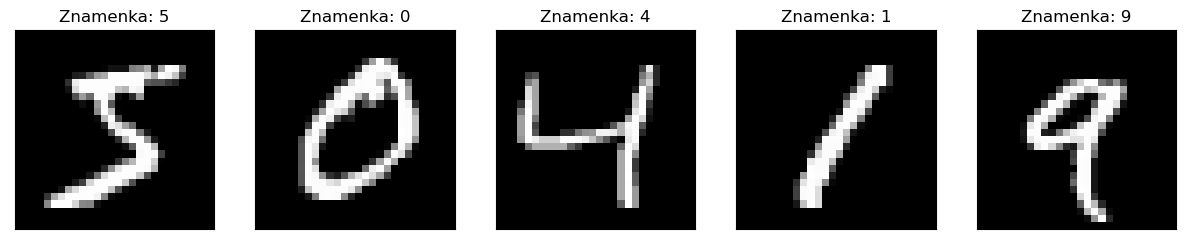

In [247]:
figure = plt.figure(figsize=(15,15))
num = 1
i = 0
for data in X_train[:5]:
    img_data = data
    y = figure.add_subplot(5,5,num)
    num = num + 1
    str_label = "Znamenka: " + str(y_train[i])
    i = i + 1
    y.imshow(np.array(img_data), cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

Spomenuli smo kako matrice koje predstavljaju slike znamenaka sadrže elemente u rasponu 0-255. No, računalo u svojoj analizi vidi samo brojeve te stoga može pridavati veću važnost onim brojevima koji su znatno veći od drugih. To za posljedicu može stvoriti neprecizan model. Uz to, dosta optimizacijskih algoritama brže konvergira među podacima koji su skalirani. Zbog toga ćemo napraviti normalizaciju podataka dijeljenjem s maksimalnom vrijednosti (255) čime će elementi matrica biti brojevi između 0 i 1.  

In [13]:
X_train = X_train / 255 
X_test = X_test / 255

Konačno, u zadnjem koraku pripreme podataka za umjetnu neuronsku mrežu, potrebno je modificirati strukturu svakog podatka na način da se njegova matrica reda 28 pretvori u jednodimenzionalno polje veličine 784. Potreba za ovom modifikacijom bit će jasna iz opisa neuronske mreže. Napomenimo kako se input neuronske mreže može podesiti tako da ipak prima dvodimenzionalnu matricu reda 28 čime donja modifikacija ne bi bila potrebna. 

In [90]:
X_train_flattened = X_train.reshape(len(X_train), 28*28)
X_test_flattened = X_test.reshape(len(X_test), 28*28)

### Umjetna neuronska mreža (1)

U nastavku promatramo poprilično jednostavnu neuronsku mrežu koja se sastoji samo od <i>input-a</i> (ulaza) i <i>output</i> sloja. Općenito, input dio služi za prikupljanje niza značajki pomoću kojih želimo doći do odgovarajuće klasifikacije podatka. U našem slučaju, podaci su slike koje su u računalu reprezentirane matricama reda 28, no na ulazu nam je potreban niz značajki (cijelih brojeva) pa smo zbog toga matricu pretvorili u jednodimenzionalno polje. Jasno, output sloj će sadržavati 10 neurona jer je toliko mogućih klasa za pojedini broj. <br>
Sada je potrebno razjasniti strukturu takve neuronske mreže pohranjene u varijabli <i>model</i>. Koristit ćemo sekvencijalni model neuronske mreže u kojem imamo stog međusobno povezanih slojeva neurona. Ostvaruje se na način da je ulaz u neuron jednog sloja zapravo izlaz neurona (može biti i više njih) prethodnog sloja. U ovom modelu imamo zapravo samo jedan (output) sloj neurona. Kako bi svaki neuron tog sloja dobio sve značajke (dakle svih 784 piksela slike) koristimo <b>dense</b> tip sloja. Output sloj definiramo pozivom <i>keras.layers.Dense()</i> gdje prvi argument predstavlja broj neurona u sloju, input_shape(784, ) definira jednodimenzionalno polje veličine 784 kao ulaz za svaki neuron u sloju, dok posljednji argument definira aktivacijsku funkciju - sigmoidu. Na slici ispod prikazana je struktura definirane neuronske mreže.

 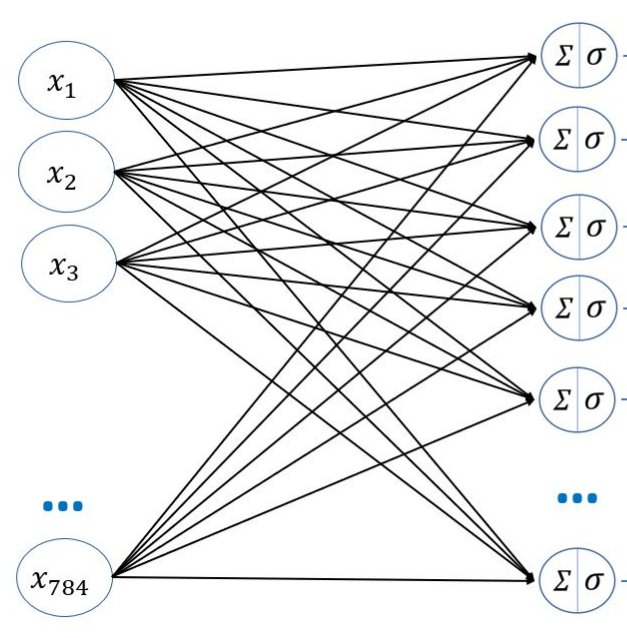

Sada je potrebno konfigurirati model za treniranje. To činimo pozivom metode <i>model.compile()</i> i odabiranjem odgovarajućih parametara. Prvi od njih je odabir optimizatora, tj. algoritma (funkcije) koji prilagođava parametre neuronske mreže u svrhu povećanja preciznosti u klasifikaciji. Postoji niz optimizatora, a svaki od njih može bitno utjecati na kvalitetu neuronske mreže. Iskustvo pokazuje da je <i><b>adam</b></i> optimizator najefikasniji zbog brze konvergencije pa smo odabrali upravo njega. Nadalje, potrebno je definirati <i>loss</i> funkciju koja uspoređuje ciljanu i predviđenu vrijednost kategorije podatka, a koju je potrebno minimizirati prilikom treniranja. Odabrali smo <i>sparse_categorical_crossentropy</i> koja se najčešće koristi za klasifikacijske probleme, a atribut <i>sparse</i> indicira da će klase biti cijeli brojevi. Kako bismo mogli ocijeniti učinkovitost modela prilikom testiranja, potrebno je uvesti funkciju metrike. Ona je slična funkciji gubitka, ali bitna razlika je ta da se rezultati funkcije metrike ne koriste prilikom treniranja. Zapravo, možemo bilo koju funkciju gubitka koristiti za metriku, i obratno. Odabrali smo <i>accuracy</i> kao funkciju metrike koja jednostavno računa omjer broja pogođenih pretpostavki i ukupnog broja pretpostavki.<br>
Konačno, treniramo model pozivom model.fit() kojem prosljeđujemo uređeni par podataka i broj epoha. U svakoj epohi za optimizaciju modela koristimo cijeli skup podataka za treniranje točno jednom.

In [214]:
model = keras.Sequential([
    keras.layers.Dense(10, input_shape=(784,), activation='sigmoid')
])

model.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'] 
)

model.fit(X_train_flattened, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.4730 - accuracy: 0.8745
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3046 - accuracy: 0.9153
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2838 - accuracy: 0.9203
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2732 - accuracy: 0.9231
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2671 - accuracy: 0.9258


### Evaluacija modela (1)

Sada evaluiramo model na skupu podataka za testiranje te na jednom od primjeraka provjeravamo uspješnost.

In [215]:
model.evaluate(X_test_flattened, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.2642 - accuracy: 0.9275


[0.2642366886138916, 0.9275000095367432]

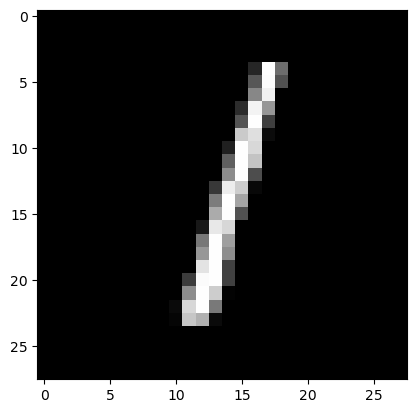

In [245]:
plt.imshow(X_test[2], cmap = 'gray')

In [217]:
y_predicted = model.predict(X_test_flattened)
y_predicted[2]

313/313 [==============================] - 1s 2ms/step


array([3.5803806e-04, 9.9276024e-01, 6.8472648e-01, 2.8275701e-01,
       2.2048317e-02, 1.0290081e-01, 1.5777127e-01, 1.1133730e-01,
       3.3541858e-01, 5.1284701e-02], dtype=float32)

Iznad vidimo vrijednosti dobivene u 10 neurona koji se nalaze u output sloju. No, odluka o klasi dolazi tako da odaberemo neuron koji sadrži najveću vrijednost, a to činimo pozivanjem <i>argmax</i> funkcije.

In [218]:
np.argmax(y_predicted[2])

1

Usporedbe radi, provjeravamo točnost predviđanja za prvih 10 znamenaka te uočavamo veliku efikasnost.

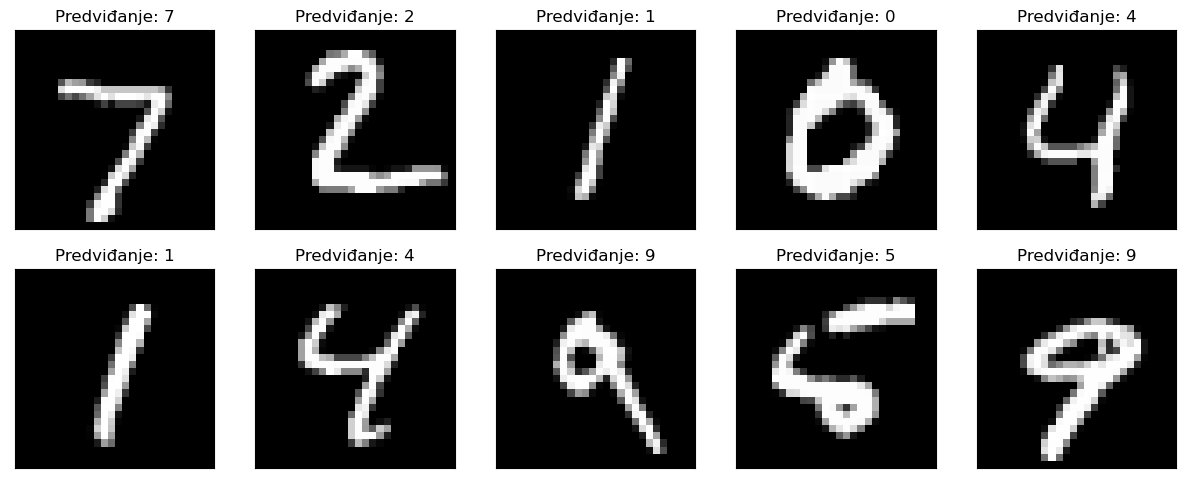

In [248]:
y_predicted_labels = [np.argmax(i) for i in y_predicted]
y_predicted_labels[:10]

figure = plt.figure(figsize=(15,15))
num = 1
i = 0
for data in X_test[:10]:
    img_data = data
    y = figure.add_subplot(5,5,num)
    num = num + 1
    str_label = "Predviđanje: " + str(y_predicted_labels[i])
    i = i + 1
    y.imshow(np.array(img_data), cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

Naravno, nije dovoljno provjeriti uspješnost na prvih nekoliko primjeraka, već je poželjno to ispitati na cijelom skupu podataka (ako je moguće). Kako bismo pregledno prikazali uspješnost modela, koristimo posebnu vrstu matrice - <i>confusion matrix</i>. Takav tip matrice upotrebljava se za vizualizaciju efikasnosti klasifikacijskih algoritama. Savršenom modelu će takva matrica biti dijagonalna. Jasno, niti jedan model nije savršen, no općenito će biti bolji oni modeli kojima je gore navedeni tip matrice što sličniji dijagonalnoj.

In [222]:
conf_mat = tf.math.confusion_matrix(labels=y_test,predictions=y_predicted_labels)

In [207]:
pip install seaborn;

Note: you may need to restart the kernel to use updated packages.


Uvest ćemo <i>seaborn</i> biblioteku koja omogućava korištenje <i>heatmap</i>-a. Confusion matrix ćemo upravo prikazati jednom heatmap-om iz koje se jasno iščitava efikasnost modela. Ukratko, što je svjetlija boja na elementima glavne dijagonale, a na ostalim što tamnija, to je model učinkovitiji.

Text(95.72222222222221, 0.5, 'Istinito')

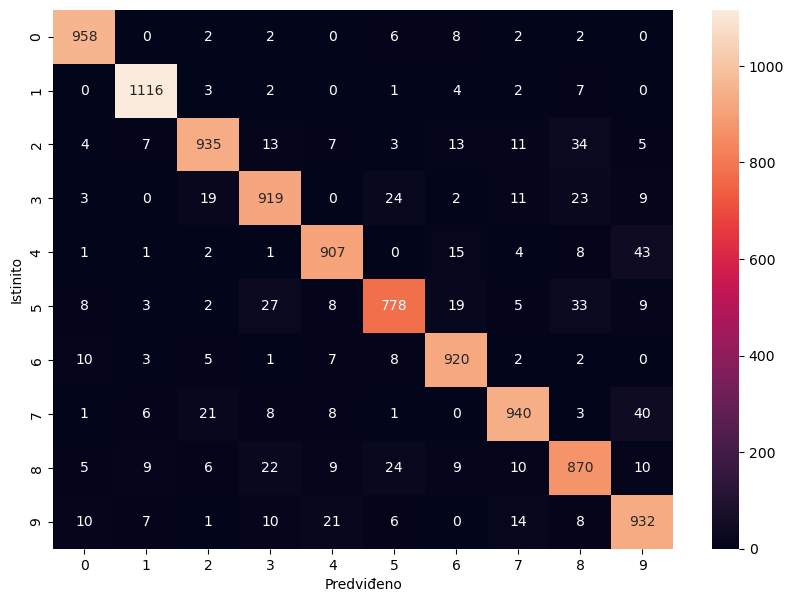

In [224]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(conf_mat, annot=True, fmt='d')
plt.xlabel('Predviđeno')
plt.ylabel('Istinito')

### Umjetna neuronska mreža (2)

Prisjetimo se: iznad smo opisali umjetnu neuronsku mrežu koja se sastoji samo od input i output sloja. Sada ćemo uvesti jedan dodatni skriveni sloj koji sadrži 100 neurona. Do na uvedeni skriveni sloj, sve je isto kao i u prvobitnoj, vrlo jednostavnoj umjetnoj neuronskoj mreži. Zbog toga nećemo posebno komentirati odsječke kodova u nastavku jer su potpuno analogni već viđenima.

In [225]:
model = keras.Sequential([
    keras.layers.Dense(100, input_shape=(784,), activation='relu'),
    keras.layers.Dense(10, activation='sigmoid')
]) 

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'] 
)

model.fit(X_train_flattened, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 7s 3ms/step - loss: 0.2821 - accuracy: 0.9205
Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1304 - accuracy: 0.9620
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0899 - accuracy: 0.9729
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0678 - accuracy: 0.9799
Epoch 5/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0539 - accuracy: 0.9829


### Evaluacija modela (2)

In [226]:
model.evaluate(X_test_flattened,y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0815 - accuracy: 0.9739


[0.08150552958250046, 0.9739000201225281]

313/313 [==============================] - 1s 2ms/step


Text(95.72222222222221, 0.5, 'Istinito')

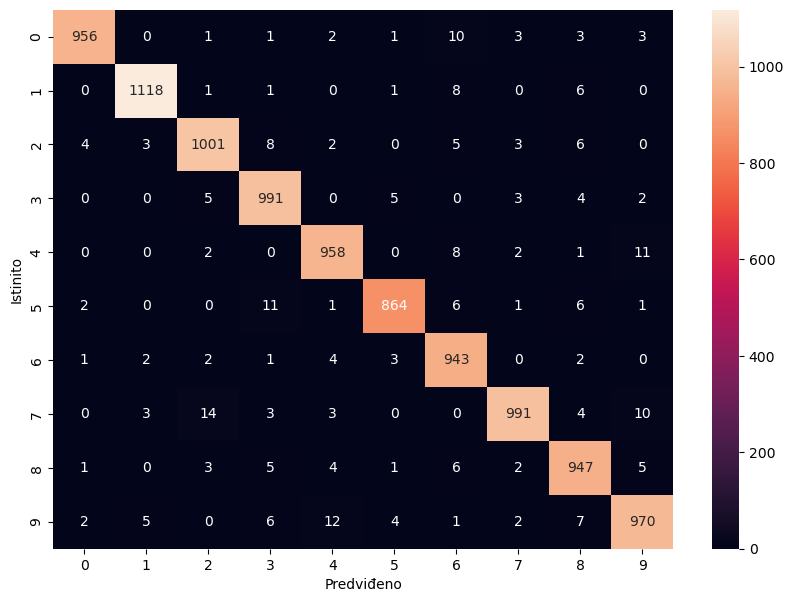

In [228]:
y_predicted = model.predict(X_test_flattened)
y_predicted_labels = [np.argmax(i) for i in y_predicted]
cm = tf.math.confusion_matrix(labels=y_test,predictions=y_predicted_labels)

plt.figure(figsize=(10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predviđeno')
plt.ylabel('Istinito')

Iz gornje matrice možemo lako iščitati da je nadograđeni model postao nešto učinkovitiji, što je bilo i za očekivati zbog dodatnog skrivenog sloja. Napomenimo kako s brojem slojeva i količinom neurona nije dobro pretjerivati zbog povećane mogućnosti za nastupanje efekta prenaučenosti.

### Dodatak: provjera efikasnosti na vlastitim crtežima znamenaka

Dosad smo provjeravali efikasnost modela na podacima koji su već bili pohranjeni u <i>keras</i> biblioteci. Kako bi stvar bila zanimljivija, autor je odlučio kreirati svoje podatke i testirati posljednji model na njima (dakle, model sa skrivenim slojem). Crteži se nalaze u datoteci <i>digits</i>, a napravljeni su u <i>paint</i>-u. U sljedećem odsječku koda uvozimo potrebne biblioteke i definiramo funkciju <i>create_test_data()</i> kojom spremamo crteže znamenaka. Biblioteka <i>tqdm</i> nije nužna te se koristi radi vizualizacije napretka prilikom dohvaćanja crteža.

In [229]:
import os
import cv2
from tqdm import tqdm

def create_test_data():
    data = []
    for img in tqdm(os.listdir("digits")):
        path = os.path.join("digits", img)
        img_data = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        data.append(np.array(img_data))
    return data

In [230]:
my_test_data = create_test_data()

100%|████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 4860.52it/s]


Sada u my_test_data imamo pohranjene crteže znamenaka. No, potrebno ih je pripremiti za ulaz u neuronsku mrežu (normalizacija i pretvorba iz dvodimenzionalnog u jednodimenzionalno polje), a to činimo na potpuno isti način kojeg smo detaljno opisali na početku. <br>
Napomenimo kako su crteži nastali odmah unutar okvira čija je visina i širina iznosila 28 piksela kako bismo izbjegli proces kompresije slike. Nadalje, koristili smo <i>np.invert</i> nad poljem slika jer su crteži znamenaka nastali tako što je pozadina bila bijele, a sama znamenka crne boje. Razlog te komplikacije leži u tome što je autor ovog rada tek nakon kreiranja slika znamenki shvatio da su podaci za treniranje u <i>keras</i> biblioteci nastali na crnoj pozadini s bijelim znamenkama. Jasno, funkcija <i>np.invert</i> pretvara piksele bijele boje u crnu boju, i obratno. Zbog toga će svi podaci biti kompatibilni.

In [231]:
temp_array = np.invert(np.array(my_test_data))
array_flattened = temp_array.reshape(len(temp_array), 28*28)
array_flattened = array_flattened / 255
my_data_predicted = model.predict(array_flattened)
my_predicted_labels = [np.argmax(i) for i in my_data_predicted]

1/1 [==============================] - 0s 32ms/step


Konačno, u nastavku je prikazano 15 crteža znamenki i predikcije modela za svaku od njih.

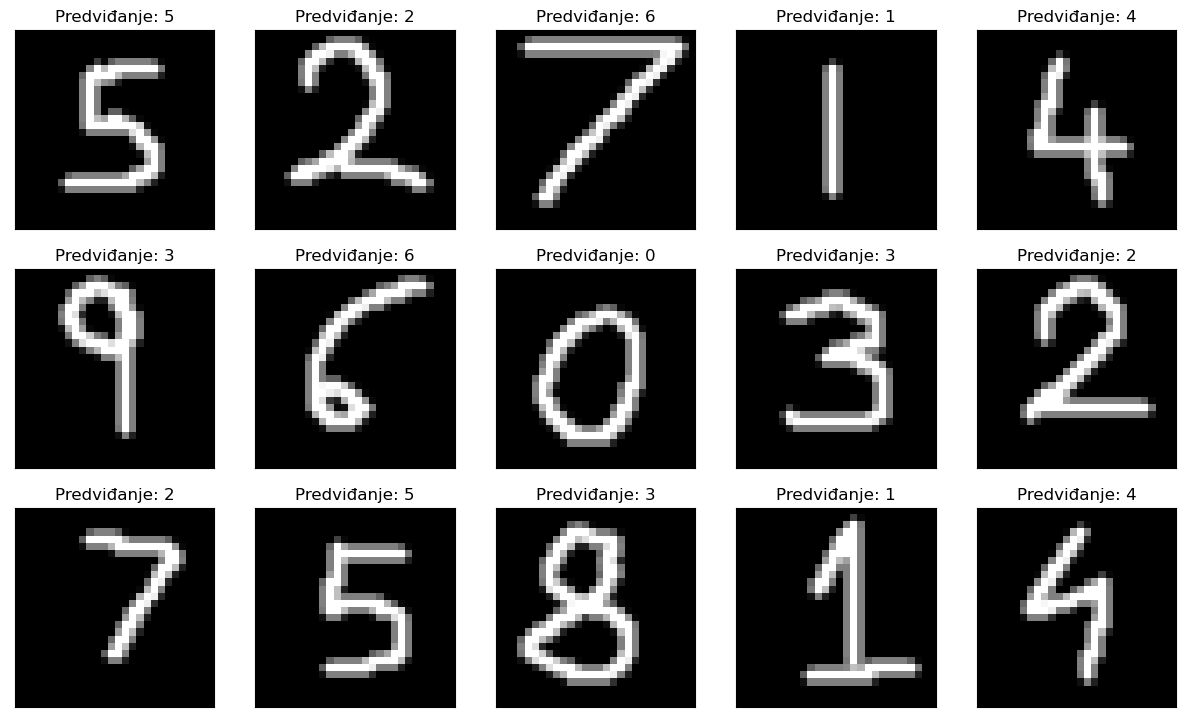

In [242]:
fig = plt.figure(figsize=(15,15))
num = 1
i = 0
for data in temp_array:
    img_data = data
    y = fig.add_subplot(5,5,num)
    num = num + 1
    str_label = "Predviđanje: " + str(my_predicted_labels[i])
    i = i + 1
    y.imshow(np.array(img_data), cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

                                                                                                            Roberto Grabovac